# Code

In [1]:
# !pip install tensorflow_addons

In [4]:
# Import Libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

c:\Users\vamsi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\vamsi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to en

In [10]:
num_classes = 10
input_shape = (32,32,3)
(x_train, y_train), (x_test, y_test) =keras.datasets.cifar10.load_data()

In [11]:
train_size=2000
test_size=500
x_train, y_train,x_test, y_test=x_train[:train_size], y_train[:train_size],x_test[:test_size], y_test[:test_size]


In [41]:
x_train.shape

(2000, 32, 32, 3)

In [42]:
x_test.shape

(500, 32, 32, 3)

# Step 2: Hyper Parameter definition

In [6]:
learning_rate =0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72
patch_size = 6
num_patches = (image_size//patch_size)**2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim*2,projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

# Step 3: Build ViT Classifier Model

3.1 Data Augmentation


In [12]:

data_augmentation = keras.Sequential([
layers.Normalization(),
layers.Resizing(image_size, image_size),
layers.RandomFlip("horizontal"),
layers.RandomRotation(factor=0.2),
layers.RandomZoom(height_factor=0.2, width_factor=0.2)
],
name="data_augmentation",)
data_augmentation.layers[0].adapt(x_train)

3.2 Define MLP Architecture

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation= tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

3.3 Patches

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call (self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, sizes = [1, self.patch_size, self.patch_size, 1],
                                            strides=[1, self.patch_size, self.patch_size, 1],rates=[1,1,1,1],
                                            padding = "VALID")
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size,-1,patch_dim])
        return patches

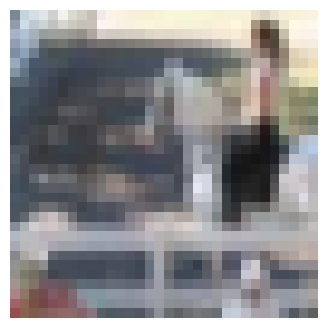

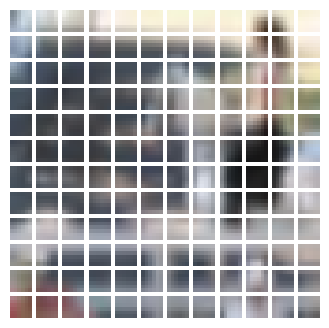

In [16]:
import matplotlib.pyplot as plt
plt. figure(figsize=(4,4)) 
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow( image)
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)

n= int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax= plt.subplot(n,n,i+1)
    patch_imag = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_imag.numpy().astype('uint8'))
    plt.axis("off")


In [48]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def call(self, patch):
        positions = tf.range(start=0,limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [49]:
def create_vit_classifier():
    inputs = layers. Input (shape=input_shape)
    augmentation =data_augmentation(inputs)
    patches = Patches(patch_size)(augmentation)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers) :
        x1 = layers. LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x4,x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [50]:
def run(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay= weight_decay)
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),],)
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy",
                                                            Save_best_only=True, save_weights_only=True)
    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1,
                callbacks=[checkpoint_callback],)
    _,accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {round(accuracy *100), 2}%")
    print(f"Test top 5 Accuracy: {round(top_5_accuracy *100), 2}%")

In [51]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/20
8/8 [==============================] - 151s 15s/step - loss: 4.9626 - accuracy: 0.1578 - top_5_accuracy: 0.5961 - val_loss: 2.2667 - val_accuracy: 0.1550 - val_top_5_accuracy: 0.6900
Epoch 2/20
8/8 [==============================] - 107s 13s/step - loss: 2.8519 - accuracy: 0.1917 - top_5_accuracy: 0.6689 - val_loss: 2.1327 - val_accuracy: 0.2550 - val_top_5_accuracy: 0.7050
Epoch 3/20
8/8 [==============================] - 86s 10s/step - loss: 2.4918 - accuracy: 0.2000 - top_5_accuracy: 0.6944 - val_loss: 2.0162 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 84s 10s/step - loss: 2.3115 - accuracy: 0.2439 - top_5_accuracy: 0.7350 - val_loss: 2.0659 - val_accuracy: 0.2550 - val_top_5_accuracy: 0.7650
Epoch 5/20
8/8 [==============================] - 100s 12s/step - loss: 2.2679 - accuracy: 0.2411 - top_5_accuracy: 0.7133 - val_loss: 2.0886 - val_accuracy: 0.2100 - val_top_5_accuracy: 0.7000
Epoch 6/20
8/8 [================

KeyboardInterrupt: 

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

10

In [ ]:
def img_predict(images, model) :
    if len(images.shape) == 3:
        out = model.predict(images.reshape(-1, *images.shape))
    else:
        out = model.predict(images)
    prediction = np.argmax(out, axis = 1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

In [ ]:
index = 16
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)